In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
resize_layer_64 = tf.keras.Sequential([
    Resizing(64, 64),
])

In [6]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 163.59it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.70it/s]


In [8]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [9]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [10]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [11]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

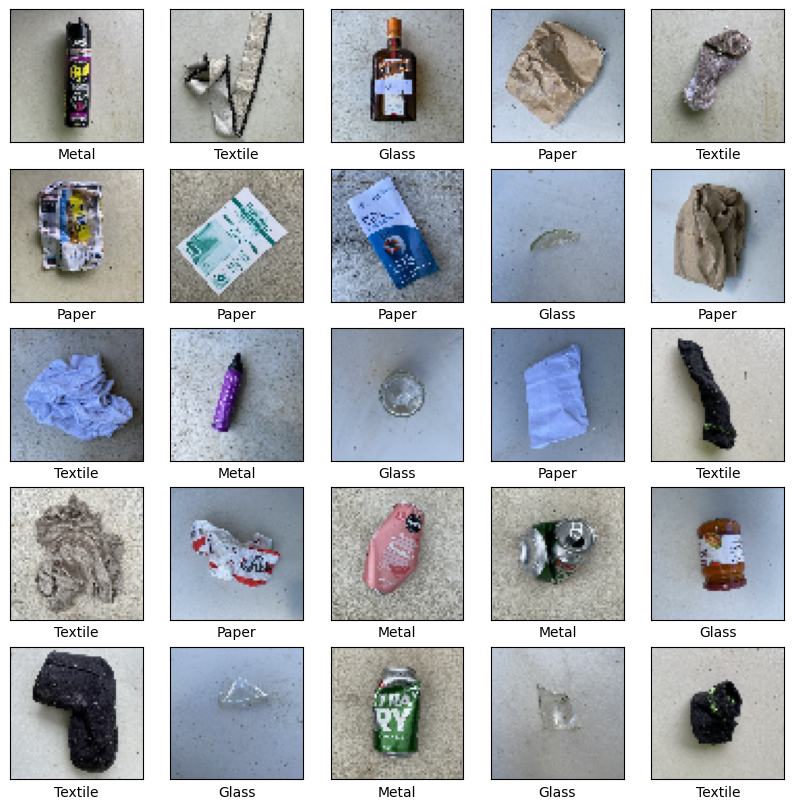

In [12]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.005), activation = 'relu'),                                                      
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.003), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l1(0.004), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 300,164 (1.15 MB)

 Trainable params: 299,460 (1.14 MB)

 Non-trainable params: 704 (2.75 KB)

In [15]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l1(0.001), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.003), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.003), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1(0.003), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l1(0.004), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 236,452 (923.64 KB)

 Trainable params: 235,876 (921.39 KB)

 Non-trainable params: 576 (2.25 KB)

In [16]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [17]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [19]:
#Learning rate scheduler for Model 1 and 2

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [20]:
# Set number of epochs and batch size
epochs = 150
batch_size = 64


In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-09 07:10:58.870160

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4127 - loss: 5.7848
Epoch 1: val_accuracy improved from -inf to 0.32407, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.4222 - loss: 5.6608 - val_accuracy: 0.3241 - val_loss: 3.6030 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6385 - loss: 3.0403
Epoch 2: val_accuracy improved from 0.32407 to 0.33333, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6403 - loss: 3.0246 - val_accuracy: 0.3333 - val_loss: 3.3235 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/ste

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9358 - loss: 0.9524
Epoch 19: val_accuracy improved from 0.42130 to 0.42593, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9367 - loss: 0.9516 - val_accuracy: 0.4259 - val_loss: 6.3699 - learning_rate: 0.0015

Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9491 - loss: 0.9151
Epoch 20: val_accuracy did not improve from 0.42593
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9488 - loss: 0.9147 - val_accuracy: 0.4028 - val_loss: 6.2063 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9536 - loss: 0.8588
Epoch 21: val_accuracy did not improve from 0.42593
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9540 - loss: 0.8583 - val_accuracy: 0.3750 -


Epoch 38: LearningRateScheduler setting learning rate to 0.0010475058457814156.
Epoch 38/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9917 - loss: 0.5128
Epoch 38: val_accuracy improved from 0.43981 to 0.45370, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9908 - loss: 0.5131 - val_accuracy: 0.4537 - val_loss: 4.0415 - learning_rate: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9886 - loss: 0.4873
Epoch 39: val_accuracy did not improve from 0.45370
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9886 - loss: 0.4869 - val_accuracy: 0.3704 - val_loss: 4.9614 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9816 - loss: 0.4922
Epoch 40: val_accuracy did not improve from 0.4537


Epoch 56: LearningRateScheduler setting learning rate to 0.00041608431201893835.
Epoch 56/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9954 - loss: 0.2925
Epoch 56: val_accuracy improved from 0.67130 to 0.76852, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9952 - loss: 0.2925 - val_accuracy: 0.7685 - val_loss: 0.9835 - learning_rate: 4.1608e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9924 - loss: 0.2897
Epoch 57: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9928 - loss: 0.2889 - val_accuracy: 0.7130 - val_loss: 1.0436 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9999 - loss: 0.2716
Epoch 58: val_accuracy improved from 0.76852

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2215
Epoch 74: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.2213 - val_accuracy: 0.8148 - val_loss: 0.7858 - learning_rate: 1.6527e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00015701091106166132.
Epoch 75/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9976 - loss: 0.2232
Epoch 75: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9976 - loss: 0.2231 - val_accuracy: 0.8333 - val_loss: 0.7561 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9993 - loss: 0.2191
Epoch 76: val_accuracy did not improve from 0.84259
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9990 - loss: 0.2193 - val_accuracy: 0.8056 - val_loss: 0.8060 - learning_rate: 1.4916e-04



Epoch 93: LearningRateScheduler setting learning rate to 6.236697954591364e-05.
Epoch 93/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9980 - loss: 0.1981
Epoch 93: val_accuracy did not improve from 0.85185
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9981 - loss: 0.1980 - val_accuracy: 0.8380 - val_loss: 0.7051 - learning_rate: 6.2367e-05

Epoch 94: LearningRateScheduler setting learning rate to 5.924862780375406e-05.
Epoch 94/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9974 - loss: 0.1973
Epoch 94: val_accuracy did not improve from 0.85185
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9976 - loss: 0.1972 - val_accuracy: 0.8426 - val_loss: 0.7059 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.1947
Epoch 95: val_accuracy did not improve from 0.85185
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 


Epoch 112: LearningRateScheduler setting learning rate to 2.3534405681857606e-05.
Epoch 112/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9999 - loss: 0.1853
Epoch 112: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9998 - loss: 0.1854 - val_accuracy: 0.8472 - val_loss: 0.6812 - learning_rate: 2.3534e-05

Epoch 113: LearningRateScheduler setting learning rate to 2.2357684792950748e-05.
Epoch 113/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.1868
Epoch 113: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.1870 - val_accuracy: 0.8472 - val_loss: 0.6855 - learning_rate: 2.2358e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.1239800207695226e-05.
Epoch 114/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.1863
Epoch 114: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step 


Epoch 131: LearningRateScheduler setting learning rate to 8.88079293872579e-06.
Epoch 131/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.1820
Epoch 131: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.1819 - val_accuracy: 0.8426 - val_loss: 0.6667 - learning_rate: 8.8808e-06

Epoch 132: LearningRateScheduler setting learning rate to 8.436753205387504e-06.
Epoch 132/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.1810
Epoch 132: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.1811 - val_accuracy: 0.8426 - val_loss: 0.6651 - learning_rate: 8.4368e-06

Epoch 133: LearningRateScheduler setting learning rate to 8.014915329113137e-06.
Epoch 133/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9978 - loss: 0.1827
Epoch 133: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - ac


Epoch 150: LearningRateScheduler setting learning rate to 3.3511995070512055e-06.
Epoch 150/150
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1778
Epoch 150: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.1779 - val_accuracy: 0.8426 - val_loss: 0.6727 - learning_rate: 3.3512e-06
Time model end: 2024-11-09 07:13:30.194879
Model_1_training_time 0:02:31.324719


In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-09 07:13:30.201589

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4129 - loss: 29.3298
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.4182 - loss: 29.2738 - val_accuracy: 0.2639 - val_loss: 26.8227 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6434 - loss: 25.6821
Epoch 2: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.6434 - loss: 25.6313 - val_accuracy: 0.2639 - val_loss: 23.6886 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6821 - loss: 22.2757
Epoch 3


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8691 - loss: 3.1710
Epoch 20: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.8693 - loss: 3.1688 - val_accuracy: 0.2639 - val_loss: 5.1163 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8502 - loss: 2.9873
Epoch 21: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.8507 - loss: 2.9831 - val_accuracy: 0.2639 - val_loss: 4.4993 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9026 - loss: 2.6846
Epoch 22: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9296 - loss: 1.5558
Epoch 38: val_accuracy did not improve from 0.52778
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.9291 - loss: 1.5563 - val_accuracy: 0.4815 - val_loss: 2.5215 - learning_rate: 6.9834e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9546 - loss: 1.4665
Epoch 39: val_accuracy did not improve from 0.52778
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.9533 - loss: 1.4685 - val_accuracy: 0.4583 - val_loss: 2.5757 - learning_rate: 6.6342e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9448 - loss: 1.4577
Epoch 40: val_accuracy improved from 0.52778 to 0.62037, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.9439 - loss: 1.4590 - val_ac

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9798 - loss: 0.9049
Epoch 56: val_accuracy improved from 0.77315 to 0.80093, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.9800 - loss: 0.9043 - val_accuracy: 0.8009 - val_loss: 1.4165 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9856 - loss: 0.8676
Epoch 57: val_accuracy did not improve from 0.80093
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.9855 - loss: 0.8673 - val_accuracy: 0.7315 - val_loss: 1.4263 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9754 - loss: 0.8603
Epoch 58: val_accuracy did not improve from 0.80093
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.9751 - loss: 0.8606 - val_ac

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9902 - loss: 0.6593 - val_accuracy: 0.8333 - val_loss: 1.1053 - learning_rate: 1.1018e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 75/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9817 - loss: 0.6650
Epoch 75: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.9819 - loss: 0.6646 - val_accuracy: 0.8148 - val_loss: 1.1248 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9886 - loss: 0.6444
Epoch 76: val_accuracy improved from 0.83333 to 0.83796, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.9883 - loss: 0.6449 - val_accuracy: 0.8380 - val_loss: 1.0751 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.4468

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9924 - loss: 0.5613
Epoch 93: val_accuracy did not improve from 0.85185
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9923 - loss: 0.5613 - val_accuracy: 0.8426 - val_loss: 1.0070 - learning_rate: 4.1578e-05

Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9897 - loss: 0.5601
Epoch 94: val_accuracy improved from 0.85185 to 0.86111, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.9899 - loss: 0.5599 - val_accuracy: 0.8611 - val_loss: 1.0080 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9824 - loss: 0.5664
Epoch 95: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.9824 - loss: 0.5665 - val_ac


Epoch 112: LearningRateScheduler setting learning rate to 1.568960378790507e-05.
Epoch 112/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9914 - loss: 0.5348
Epoch 112: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.9914 - loss: 0.5350 - val_accuracy: 0.8611 - val_loss: 0.9383 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9877 - loss: 0.5418
Epoch 113: val_accuracy did not improve from 0.86111
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.9876 - loss: 0.5420 - val_accuracy: 0.8611 - val_loss: 0.9245 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9976 - loss: 0.5262
Epoch 114: val_accuracy improved from 0.86111 to 0.86574, saving model to C:/Mani/ModelChe

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9970 - loss: 0.5199
Epoch 130: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.9968 - loss: 0.5199 - val_accuracy: 0.8611 - val_loss: 0.9137 - learning_rate: 6.2321e-06

Epoch 131: LearningRateScheduler setting learning rate to 5.920527905800554e-06.
Epoch 131/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9922 - loss: 0.5252
Epoch 131: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.9922 - loss: 0.5252 - val_accuracy: 0.8611 - val_loss: 0.9152 - learning_rate: 5.9205e-06

Epoch 132: LearningRateScheduler setting learning rate to 5.624501704915019e-06.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9917 - loss: 0.5304
Epoch 132: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.9918 - loss: 0.5301 - val_accuracy: 0.8611 - val_loss: 0.9152 - learning_rate: 


Epoch 149: LearningRateScheduler setting learning rate to 2.3517189220001454e-06.
Epoch 149/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9948 - loss: 0.5189
Epoch 149: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9948 - loss: 0.5186 - val_accuracy: 0.8611 - val_loss: 0.9120 - learning_rate: 2.3517e-06

Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9931 - loss: 0.5073
Epoch 150: val_accuracy did not improve from 0.87037
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.9929 - loss: 0.5078 - val_accuracy: 0.8519 - val_loss: 0.9123 - learning_rate: 2.2341e-06
Time model end: 2024-11-09 07:24:08.814598
Model_2_training_time 0:10:38.613009


In [23]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-09 07:24:08.821835

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3554 - loss: 23.3279
Epoch 1: val_accuracy improved from -inf to 0.34722, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.3602 - loss: 23.2918 - val_accuracy: 0.3472 - val_loss: 22.0847 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5623 - loss: 21.4761
Epoch 2: val_accuracy did not improve from 0.34722
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.5637 - loss: 21.4517 - val_accuracy: 0.2639 - val_loss: 20.7664 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6369 - loss: 19.8657



Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8322 - loss: 3.4415
Epoch 20: val_accuracy did not improve from 0.34722
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8310 - loss: 3.4379 - val_accuracy: 0.2639 - val_loss: 4.3168 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8242 - loss: 3.2368
Epoch 21: val_accuracy did not improve from 0.34722
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.8244 - loss: 3.2363 - val_accuracy: 0.2639 - val_loss: 4.4272 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 22/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8417 - loss: 3.0534
Epoch 22: val_accuracy did not improve from 0.34722
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.8380 - loss: 1.8195 - val_accuracy: 0.3889 - val_loss: 2.8323 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8650 - loss: 1.7255
Epoch 39: val_accuracy improved from 0.38889 to 0.51852, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.8652 - loss: 1.7239 - val_accuracy: 0.5185 - val_loss: 2.3591 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8914 - loss: 1.6103
Epoch 40: val_accuracy did not improve from 0.51852
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8902 - loss: 1.6129 - val_accuracy: 0.5000 - val_loss: 2.4180 - learning_rate: 9.8000e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.00098


Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9303 - loss: 1.1120
Epoch 57: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.9303 - loss: 1.1117 - val_accuracy: 0.6806 - val_loss: 1.6993 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9512 - loss: 1.0290
Epoch 58: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.9512 - loss: 1.0291 - val_accuracy: 0.6574 - val_loss: 1.7084 - learning_rate: 5.2955e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0005030752246966585.
Epoch 59/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9472 - loss: 0.9906
Epoch 59: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accur


Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9787 - loss: 0.7086
Epoch 76: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.9779 - loss: 0.7100 - val_accuracy: 0.7546 - val_loss: 1.2071 - learning_rate: 2.1035e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00019982864396297372.
Epoch 77/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9681 - loss: 0.7098
Epoch 77: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9682 - loss: 0.7100 - val_accuracy: 0.7500 - val_loss: 1.2529 - learning_rate: 1.9983e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.00018983721383847296.
Epoch 78/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9814 - loss: 0.6773
Epoch 78: val_accuracy improved from 0.77315 to 0.78704, saving model to C:/Mani/ModelCheckpoint

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9886 - loss: 0.5652
Epoch 94: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.9886 - loss: 0.5656 - val_accuracy: 0.7824 - val_loss: 1.0646 - learning_rate: 8.3552e-05

Epoch 95: LearningRateScheduler setting learning rate to 7.937479786050972e-05.
Epoch 95/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9849 - loss: 0.5636
Epoch 95: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.9851 - loss: 0.5632 - val_accuracy: 0.8056 - val_loss: 1.0207 - learning_rate: 7.9375e-05

Epoch 96: LearningRateScheduler setting learning rate to 7.540605693066026e-05.
Epoch 96/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9957 - loss: 0.5513
Epoch 96: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.9956 - loss: 0.5513 - val_accuracy: 0.7917 - val_loss: 1.0219 - learning_rate: 7.5406e


Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9889 - loss: 0.5107
Epoch 113: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.9888 - loss: 0.5113 - val_accuracy: 0.8148 - val_loss: 0.9729 - learning_rate: 3.1529e-05

Epoch 114: LearningRateScheduler setting learning rate to 2.9952368458907584e-05.
Epoch 114/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9876 - loss: 0.5215
Epoch 114: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.9873 - loss: 0.5220 - val_accuracy: 0.8148 - val_loss: 0.9599 - learning_rate: 2.9952e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.8454750554374184e-05.
Epoch 115/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9861 - loss: 0.5270
Epoch 115: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms


Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9792 - loss: 0.5150
Epoch 132: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.9795 - loss: 0.5145 - val_accuracy: 0.8194 - val_loss: 0.9631 - learning_rate: 1.1898e-05

Epoch 133: LearningRateScheduler setting learning rate to 1.1302634857202064e-05.
Epoch 133/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9883 - loss: 0.4928
Epoch 133: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.9883 - loss: 0.4931 - val_accuracy: 0.8148 - val_loss: 0.9623 - learning_rate: 1.1303e-05

Epoch 134: LearningRateScheduler setting learning rate to 1.0737502725532977e-05.
Epoch 134/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9877 - loss: 0.4960
Epoch 134: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms

Time model end: 2024-11-09 07:35:53.348059
Model_3_training_time 0:11:44.526224


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:4.4)')

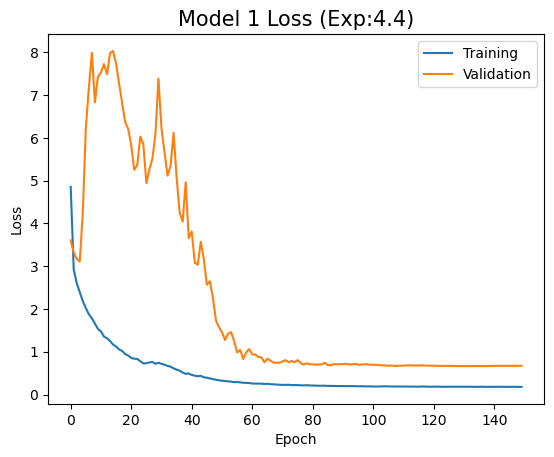

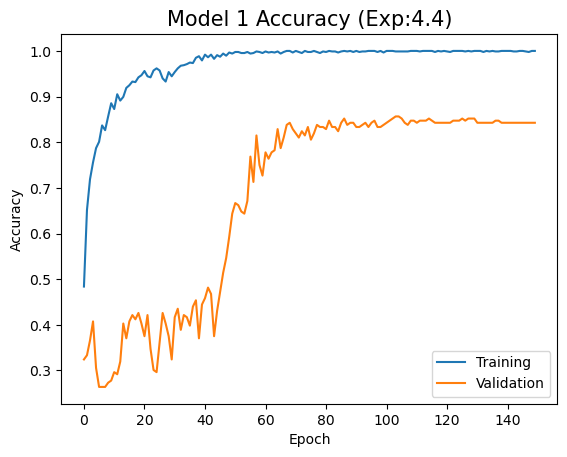

In [24]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:4.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:4.4)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:4.4)')

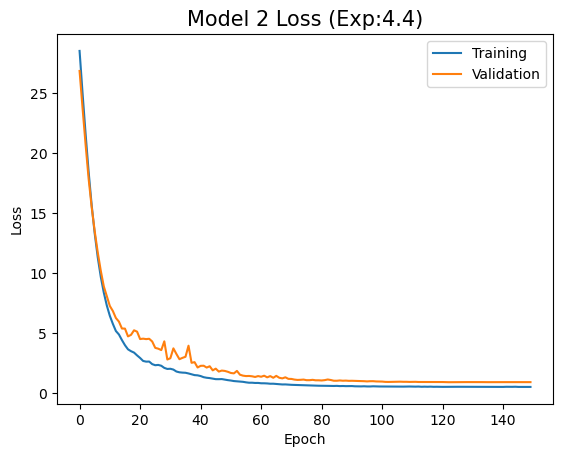

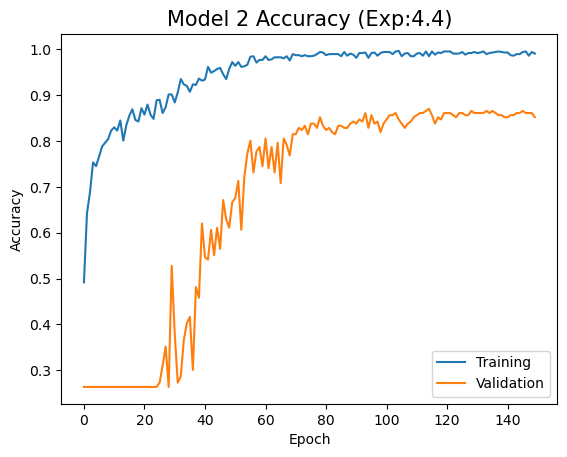

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:4.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:4.4)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:4.4)')

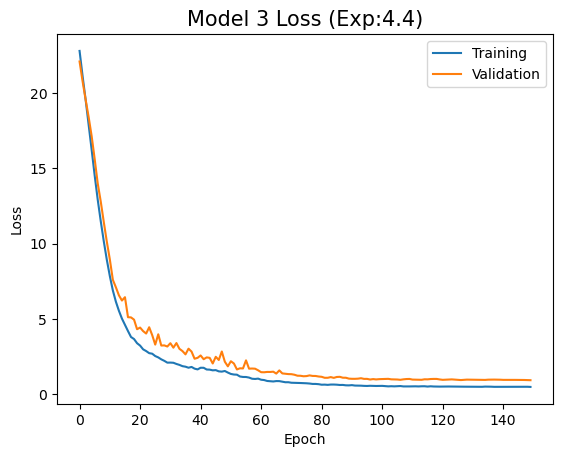

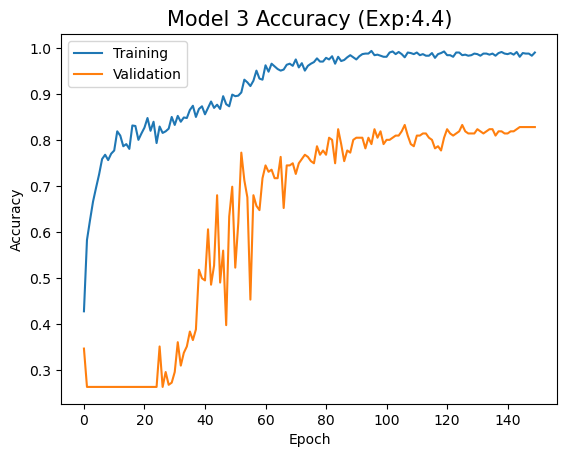

In [26]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:4.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:4.4)', fontsize = 15)

In [27]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8234 - loss: 0.7194
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8331 - loss: 1.0797
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7768 - loss: 1.0767


In [28]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


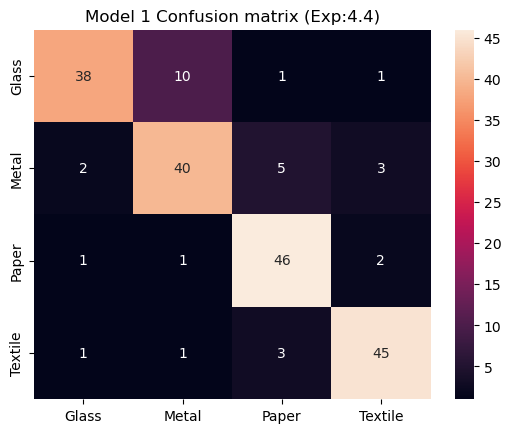

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:4.4)')
plt.show()

In [30]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


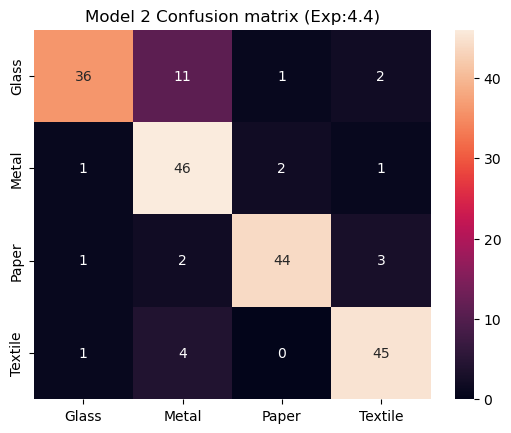

In [31]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:4.4)')
plt.show()

In [32]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


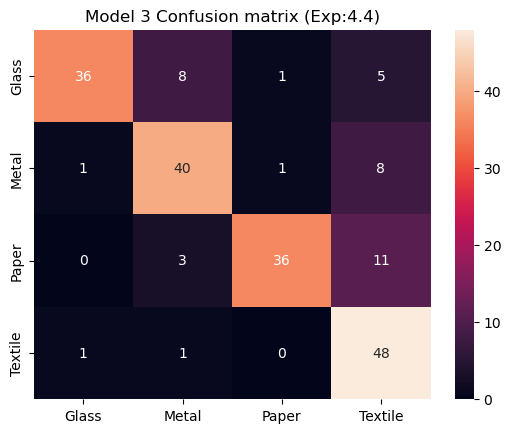

In [33]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:4.4)')
plt.show()